# warm and cold anomalies

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import dask
import cartopy.feature as cfeature
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import intake
import cartopy.crs as ccrs
from tempfile import TemporaryDirectory
from getpass import getuser
from pathlib import Path
from dask.distributed import Client, LocalCluster
import subprocess
import re
import cartopy.crs as ccrs
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('/home/b/b382616/notebooks_home/MHW/spot_the_blob')

import spot_the_blOb.hot_to_blOb as hot

import dask
from dask.distributed import Client, LocalCluster
import bokeh

dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
cluster = LocalCluster(n_workers=32, threads_per_worker=4)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/b382616/levante-spawner-preset//proxy/8787/status,
Dashboard: /user/b382616/levante-spawner-preset//proxy/8787/status,Workers: 32
Total threads: 128,Total memory: 235.37 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44807,Workers: 32
Dashboard: /user/b382616/levante-spawner-preset//proxy/8787/status,Total threads: 128
Started: Just now,Total memory: 235.37 GiB
Comm: tcp://127.0.0.1:34453,Total threads: 4
Dashboard: /user/b382616/levante-spawner-preset//proxy/45055/status,Memory: 7.36 GiB
Nanny: tcp://127.0.0.1:41017,


In [2]:
# OBSERVATION
cat = intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")

dat = cat['dkrz.disk.observations.OSTIA.OSTIA.daily']#-output'][model][expid][version]['ocean'][gridspec]
sst = dat(chunks={}).to_dask()
sst=sst['sst'].coarsen(lat=5, lon=5,boundary='pad').mean()
sst=sst.isel(time=slice(0,13879))
extreme_events_ds = hot.preprocess_data(sst,detrend_orders=[1,2], std_normalise=False, threshold_percentile=95)
ssta_ic=extreme_events_ds['dat_detrend']
ssta=ssta_ic

In [ ]:
warm_std = ssta.where(ssta > 0).std(dim='time', skipna=True)
cold_std = ssta.where(ssta < 0).std(dim='time', skipna=True)

In [ ]:
warm_std=warm_std.persist()

warm_std=warm_std.compute()

In [ ]:
cold_std=cold_std.persist()
cold_std=cold_std.compute()

In [37]:
#ICON
file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'extreme_events_binary_ord2.zarr'
chunk_size = {'time': 25, 'lat': -1, 'lon': -1}
ds = xr.open_zarr(str(file_name), chunks=chunk_size)
ssta=ds['dat_detrend']

In [38]:
#dataset="OSTIA (1982-2019)"
dataset="ICON phase 1 control run"

In [39]:
warm_std_ic = ssta.where(ssta > 0).std(dim='time', skipna=True)
cold_std_ic = ssta.where(ssta < 0).std(dim='time', skipna=True)

In [40]:
warm_std_ic=warm_std_ic.persist()

warm_std_ic=warm_std_ic.compute()

/home/b/b382616/.local/lib/python3.9/site-packages/dask/array/numpy_compat.py:56: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [41]:
cold_std_ic=cold_std_ic.persist()
cold_std_ic=cold_std_ic.compute()

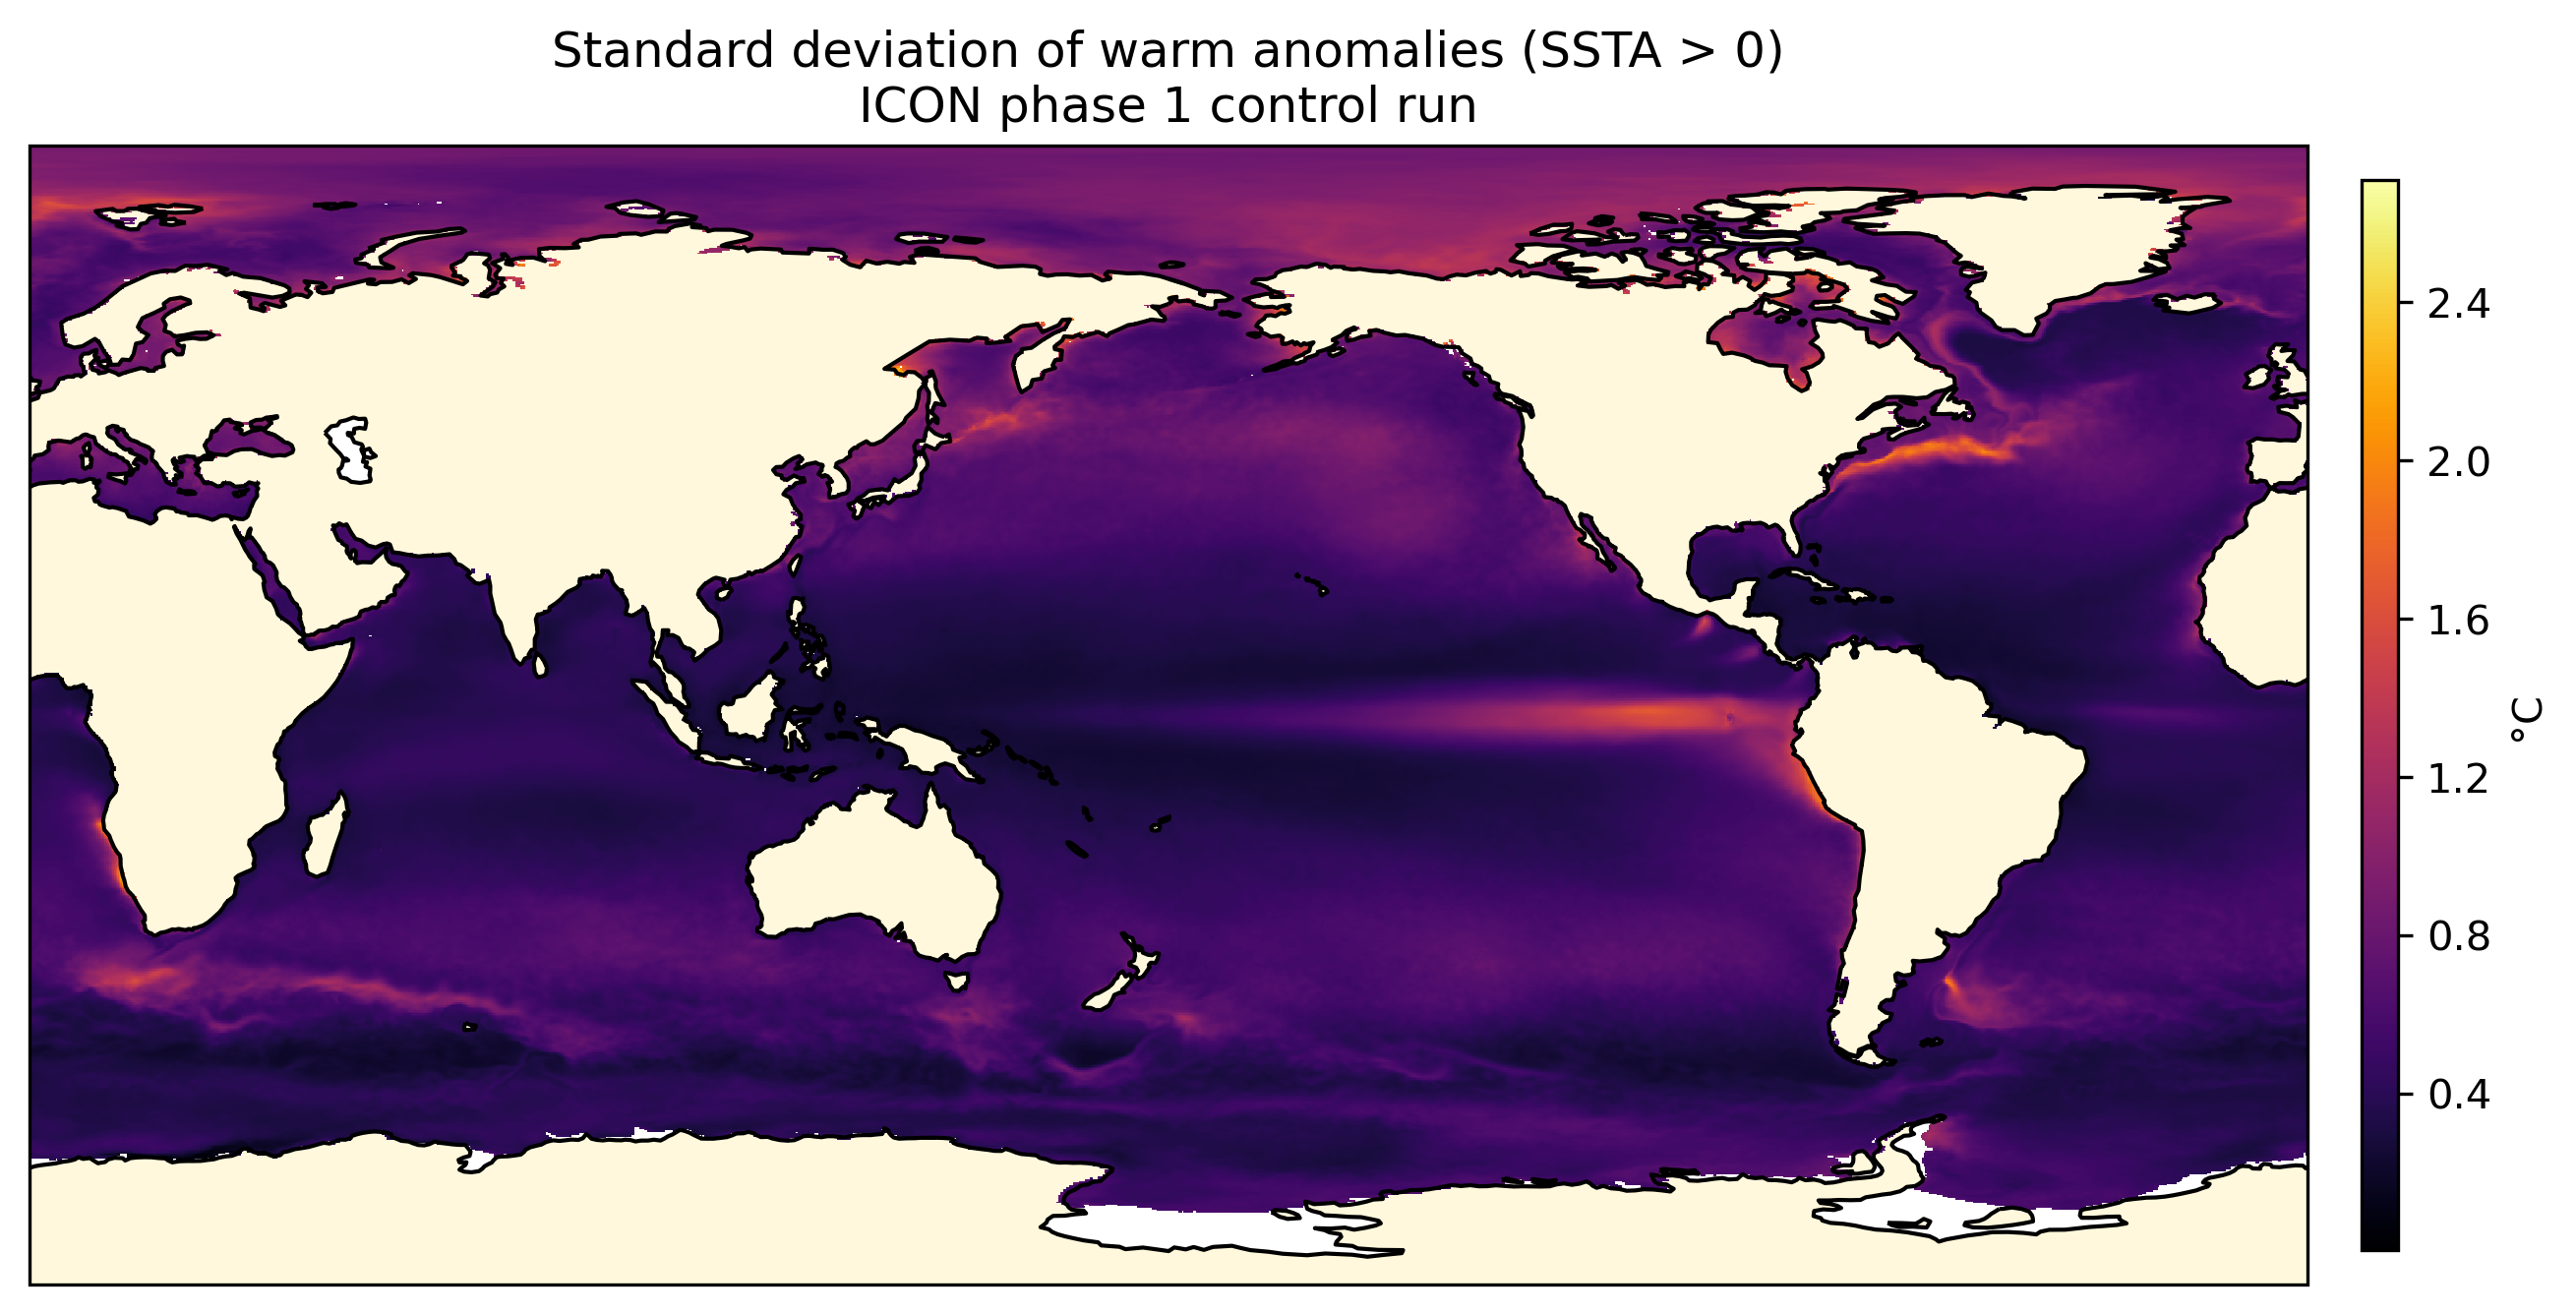

In [45]:
#var=warm_std
var=warm_std_ic

fig = plt.figure(figsize=(12, 6),dpi=300)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))  
ax.set_global()  
ax.add_feature(cfeature.LAND, facecolor='cornsilk')

ax.coastlines()
pcm = ax.pcolormesh(var.lon, var.lat, var, cmap='inferno', transform=ccrs.PlateCarree())


cbar = fig.colorbar(pcm, ax=ax, orientation="vertical", shrink=0.8, pad=0.02, aspect=30)

# Increase the number of ticks
cbar.set_ticks(ticker.MaxNLocator(nbins=8))  # Adjust nbins as needed

cbar.set_label("°C")

# Title
plt.title("Standard deviation of warm anomalies (SSTA > 0)\n"+dataset)

plt.show()


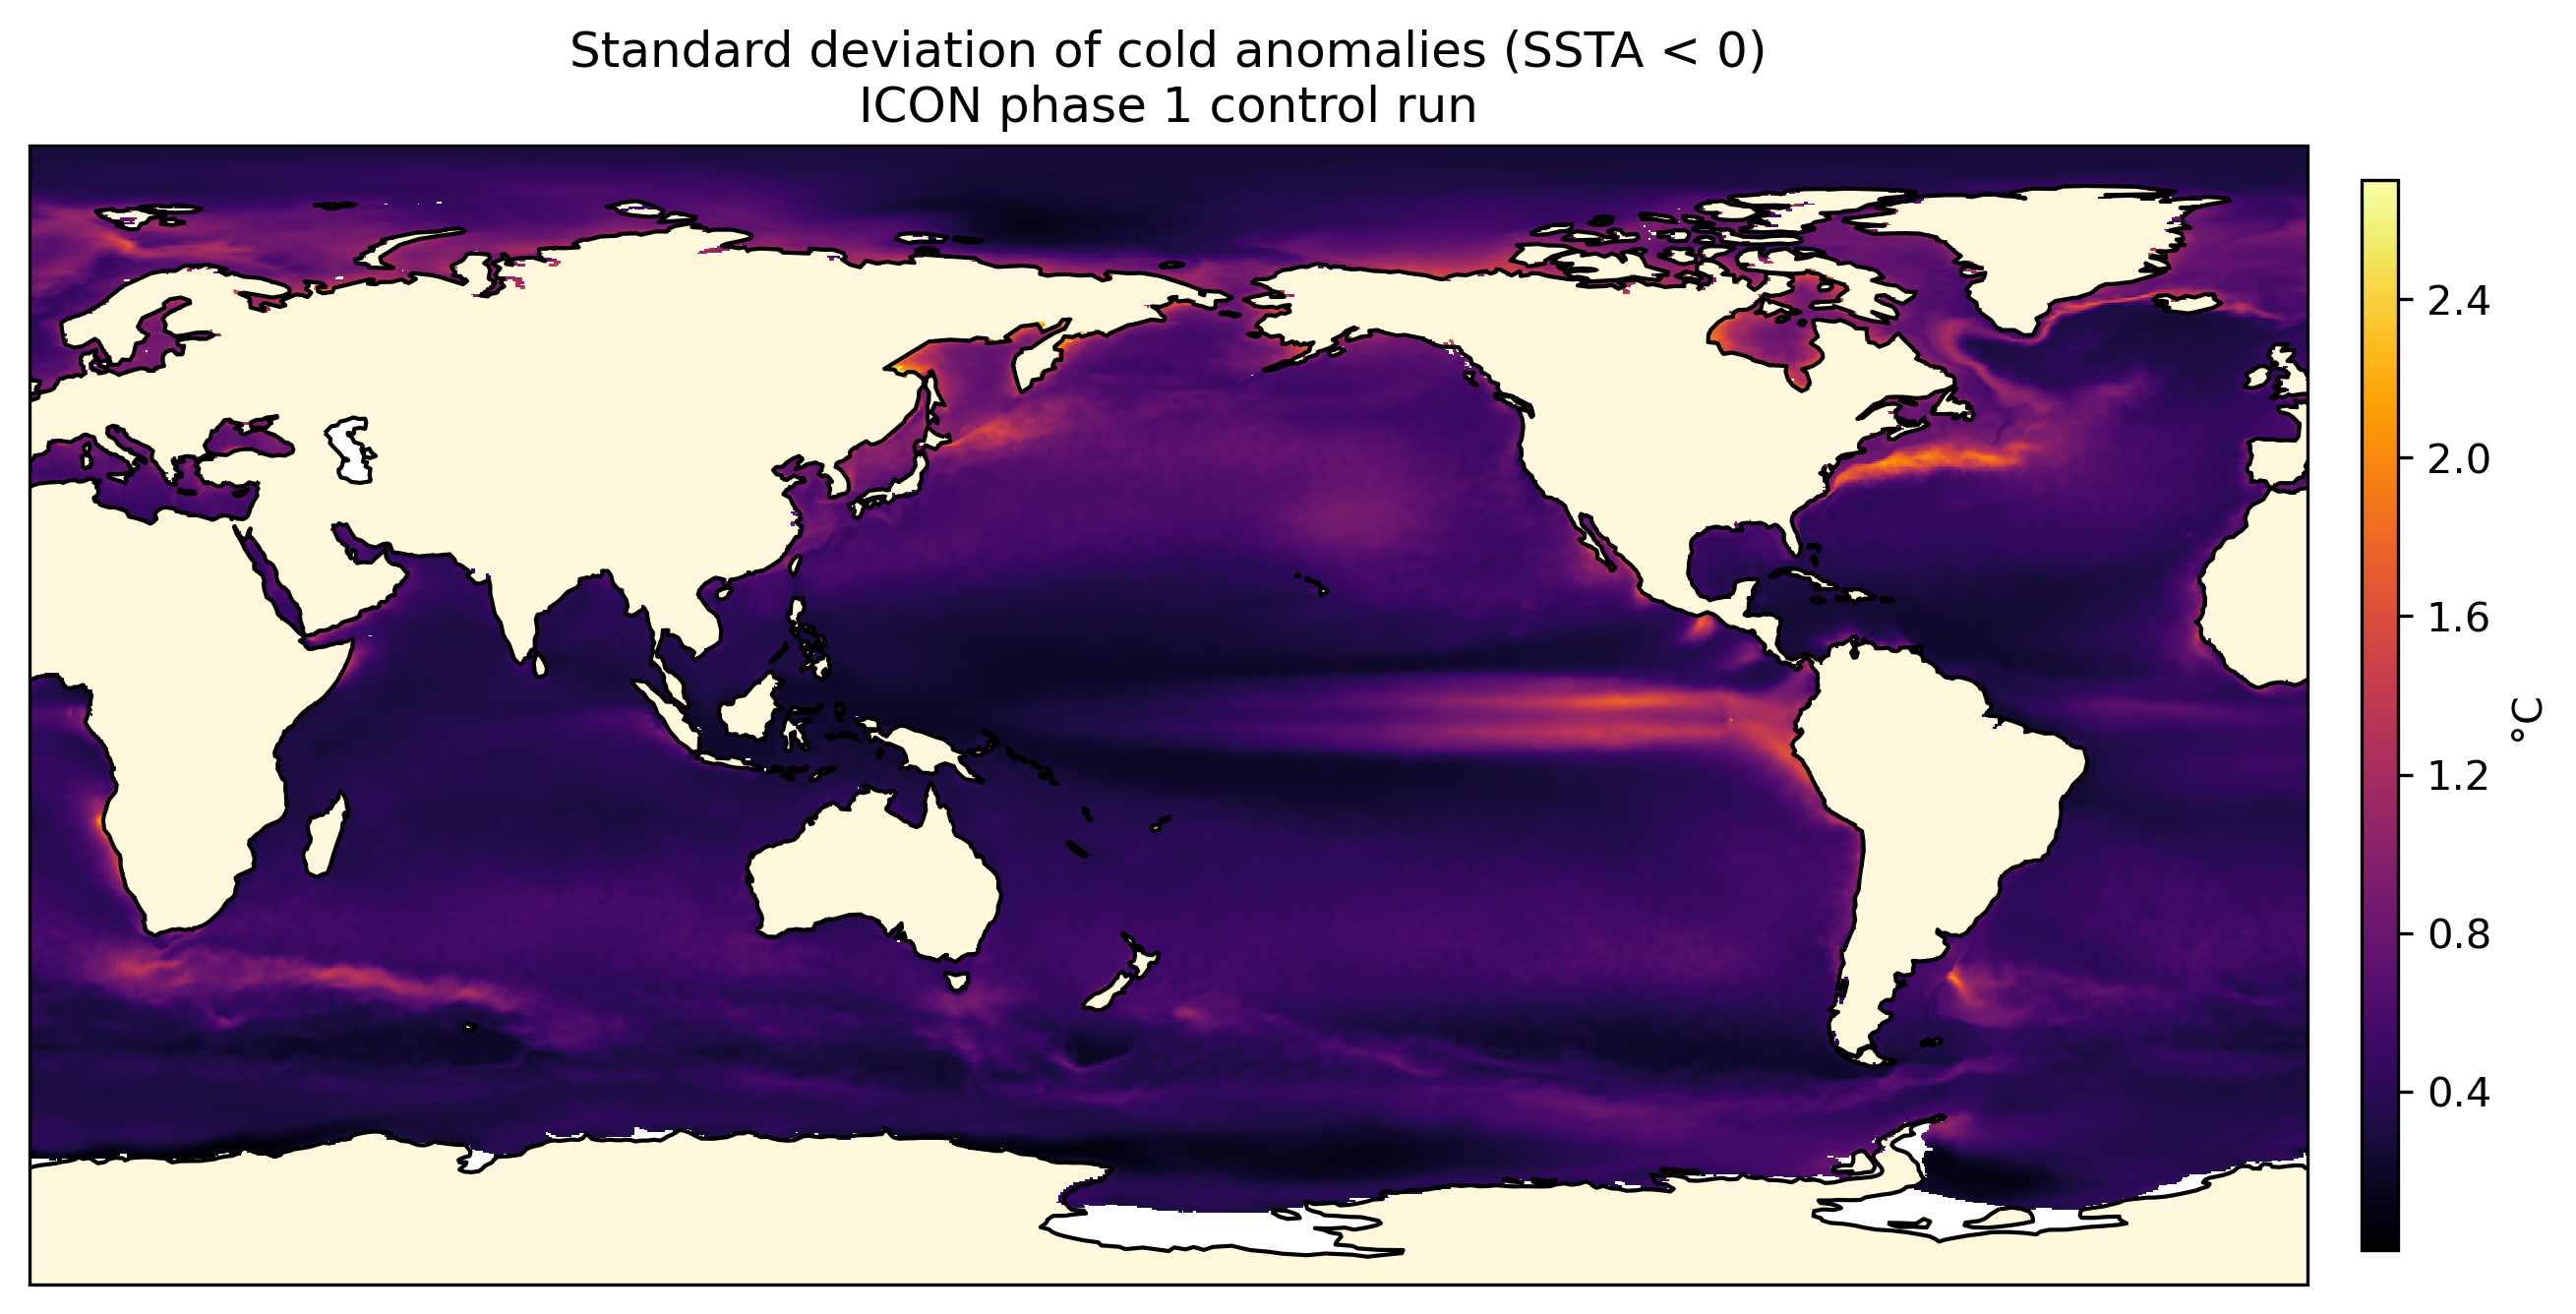

In [47]:
#var=cold_std
var=cold_std_ic


fig = plt.figure(figsize=(12, 6),dpi=300)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))  
ax.set_global()  
ax.add_feature(cfeature.LAND, facecolor='cornsilk')

ax.coastlines()
pcm = ax.pcolormesh(var.lon, var.lat, var,vmax=2.7, cmap='inferno', transform=ccrs.PlateCarree())


cbar = fig.colorbar(pcm, ax=ax, orientation="vertical", shrink=0.8, pad=0.02, aspect=30)

# Increase the number of ticks
cbar.set_ticks(ticker.MaxNLocator(nbins=8))  # Adjust nbins as needed

cbar.set_label("°C")

# Title
plt.title("Standard deviation of cold anomalies (SSTA < 0)\n"+dataset)

plt.show()


In [52]:
np.nanmean(var1-var2)

0.077322907707946

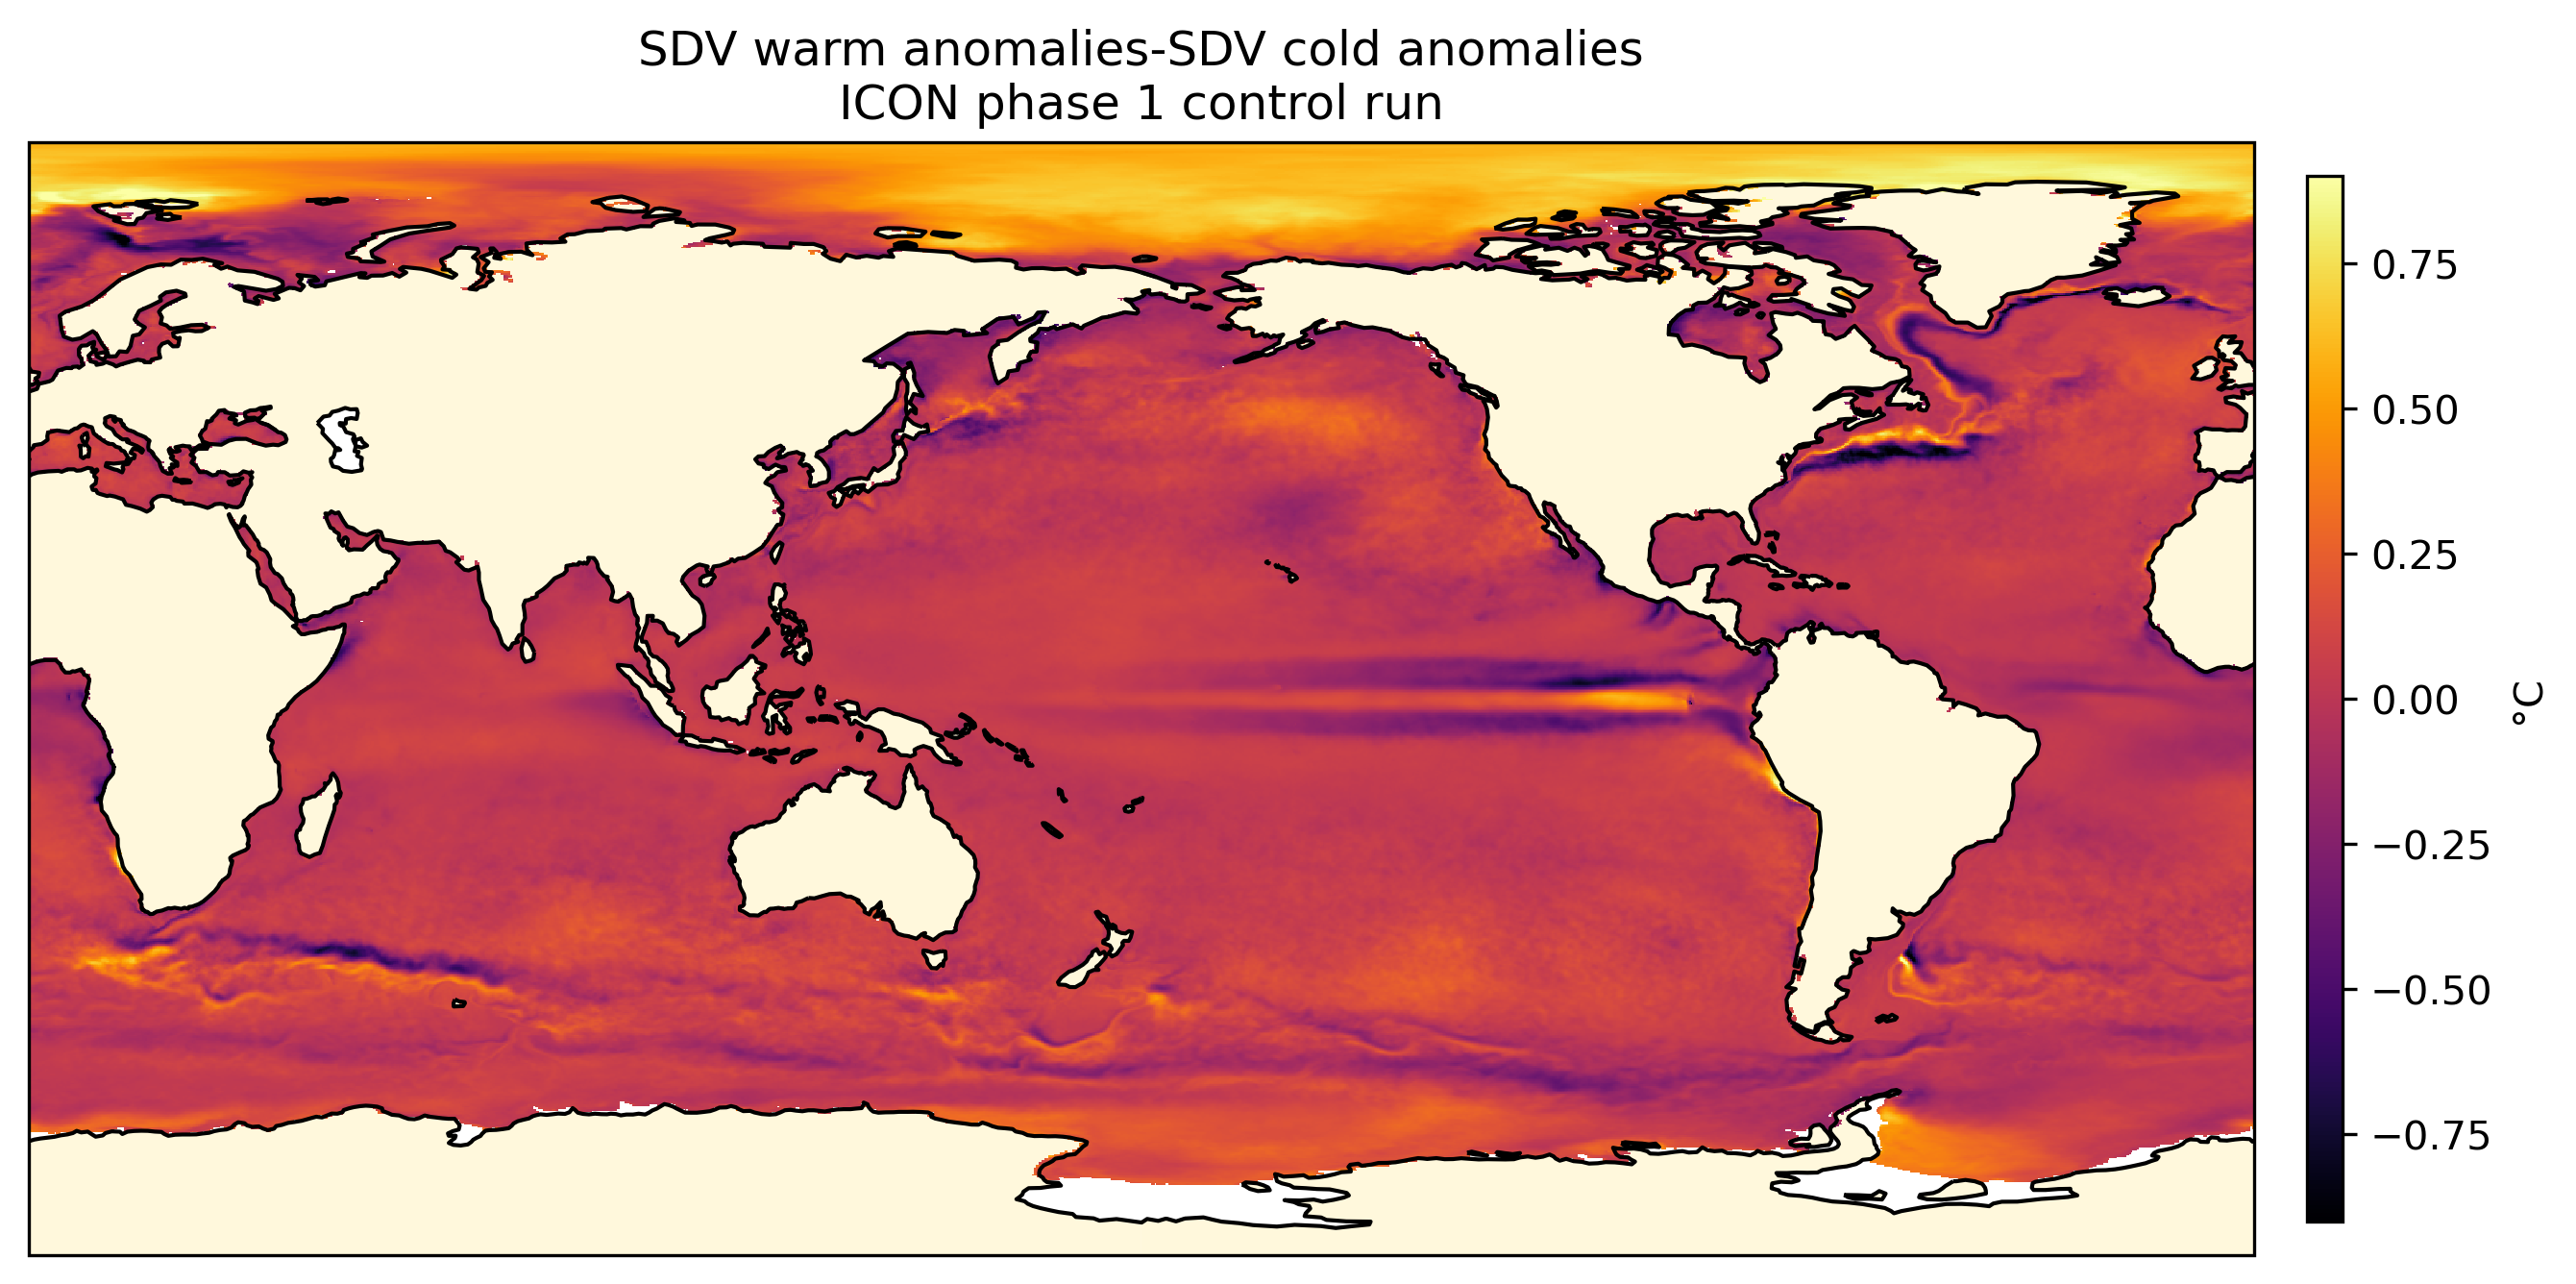

In [54]:
var1=warm_std_ic
var2=cold_std_ic

fig = plt.figure(figsize=(12, 6),dpi=300)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))  
ax.set_global()  
ax.add_feature(cfeature.LAND, facecolor='cornsilk')

ax.coastlines()
pcm = ax.pcolormesh(var1.lon, var1.lat, var1-var2,vmin=-0.9,vmax=0.9, cmap='inferno', transform=ccrs.PlateCarree())


cbar = fig.colorbar(pcm, ax=ax, orientation="vertical", shrink=0.8, pad=0.02, aspect=30)

# Increase the number of ticks
cbar.set_ticks(ticker.MaxNLocator(nbins=8))  # Adjust nbins as needed

cbar.set_label("°C")

# Title
plt.title("SDV warm anomalies-SDV cold anomalies\n"+dataset)

plt.show()
